In [1]:
import numpy as np
import matplotlib.pyplot as plt
from imaids.models import Kyma22
from idanalysis import IDKickMap
from scipy.optimize import curve_fit
import sympy
import utils

In [2]:
kyma = utils.generate_radia_model(phase=0)

In [3]:
def get_field_on_axis(kyma, rz, y, x, plot_flag=True):
    field = kyma.get_field(x, y, rz)
    bx = field[:, 0]
    by = field[:, 1]
    bz = field[:, 2]

    if plot_flag:
        plt.plot(rz, bx, label='Bx')
        plt.plot(rz, by, label='By')
        plt.plot(rz, bz, label='Bz')
        plt.xlabel('rz [mm]')
        plt.ylabel('Field [T]')
        plt.legend()
        plt.grid()
        plt.show()

    return bx, by, bz

In [4]:
def get_field_roll_off(kyma, rx, peak_idx, x=0, y=0, plot_flag=True, component='y'):
    """."""
    if component=='y':
        fidx = 1
    elif component=='z':
        fidx = 2 
    else:
        fidx = 0
    period = kyma.period_length
    rz = np.linspace(-period/2, period/2, 100)
    field = kyma.get_field(x, y, rz)
    by = field[:, fidx]
    by_max_idx = np.argmax(by)
    rz_at_max = rz[by_max_idx] + peak_idx*period
    field = kyma.get_field(rx, y, rz_at_max)
    by = field[:, fidx]
    rx5_idx = np.argmin(np.abs(rx - 5))
    rx0_idx = np.argmin(np.abs(rx))
    roff = np.abs(by[rx5_idx]/by[rx0_idx]-1)
    print('roll off = ', 100*roff, '%')
    if plot_flag:
        plt.plot(rx, by)
        plt.xlabel('x [mm]')
        plt.ylabel('Bz [T]')
        plt.title('Field rolloff at x = 5 mm')
        plt.grid()
        plt.show()

    return by

In [5]:
rz = np.linspace(-100, 100, 801)
rx = np.linspace(-10, 10, 4*81)
ry = np.linspace(-3, 3, 25)

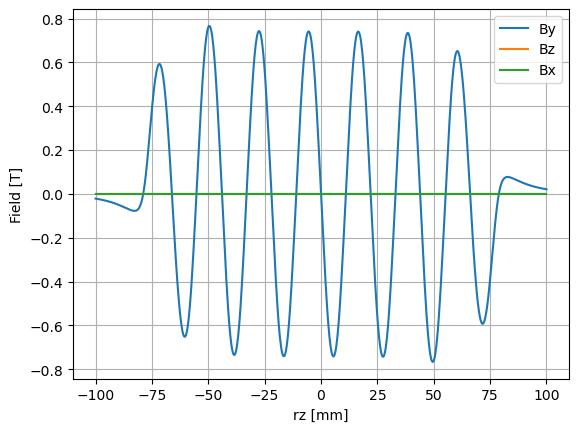

In [6]:
kyma.dp = 0
bx, by, bz = get_field_on_axis(kyma, rz, x=0, y=0, plot_flag=False)
# plt.plot(rz, bx, label='Bx')
plt.plot(rz, by, label='By')
plt.plot(rz, bz, label='Bz')
plt.plot(rz, bx, label='Bx')
plt.xlabel('rz [mm]')
plt.ylabel('Field [T]')
plt.legend()
plt.grid()
plt.show()


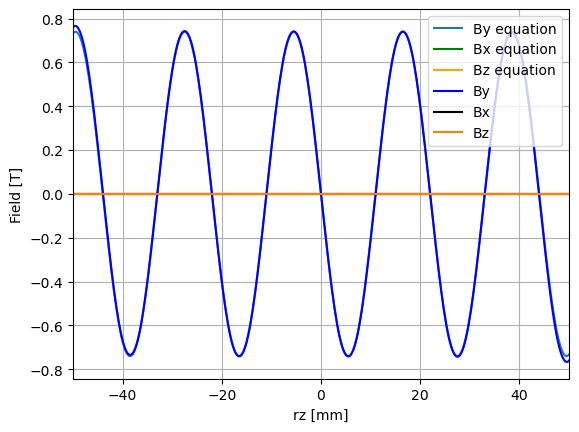

In [7]:
period = kyma.period_length
width = 30
dp = 0
eta = 11.65
y=0
x=0
kyma.dp = dp
bx, by, bz = get_field_on_axis(kyma, rz, x=x, y=y, plot_flag=False)
b0 = 0.74
kz = 2*np.pi/period
kx = 2*np.pi/(eta*width)
ky = np.sqrt(kx**2+kz**2)
by_eq = -b0/2*np.cos(kx*x)*(np.exp(-ky*y)*np.sin(kz*rz)+np.exp(ky*y)*np.sin(kz*rz-kz*dp))
bx_eq = -kx/ky*b0/2*np.sin(kx*x)*(np.exp(-ky*y)*np.sin(kz*rz)-np.exp(ky*y)*np.sin(kz*rz-kz*dp))
bz_eq = kz/ky*b0/2*np.cos(kx*x)*(np.exp(-ky*y)*np.cos(kz*rz)-np.exp(ky*y)*np.cos(kz*rz-kz*dp))

plt.plot(rz, by_eq, color='C0', label='By equation')
plt.plot(rz, bx_eq, color='g', label='Bx equation')
plt.plot(rz, bz_eq, color='orange', label='Bz equation')
plt.plot(rz, by, color='b', label='By')
plt.plot(rz, bx, color='k', label='Bx')
plt.plot(rz, bz, color='C1', label='Bz')
plt.xlabel('rz [mm]')
plt.ylabel('Field [T]')
plt.xlim(-50, 50)
plt.legend()
plt.grid()
plt.show()

roll off =  0.017497490864937237 %
0.7410961228421314
kx =  0.018694317858067598


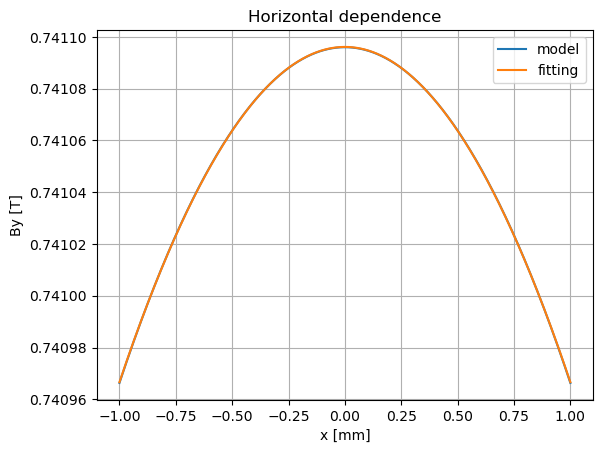

In [8]:
kxl = list()
phil = list()
def cos(x, b0, kx):
    b = b0*np.cos(kx*x)
    return b
phases = [0]
rx = np.linspace(-1, 1, 1000)
for dp in phases:
    kyma.dp = dp
    by = get_field_roll_off(kyma, rx, y=0, peak_idx=0, plot_flag=False, component='y')
    opt = curve_fit(cos, rx, by)[0]
    print(opt[0])
    print('kx = ', opt[1])
    b_fitted = cos(rx, opt[0], opt[1])
    plt.plot(rx, by, label='model')
    plt.plot(rx, b_fitted, label='fitting')
    plt.xlabel('x [mm]')
    plt.ylabel('By [T]')
    plt.title('Horizontal dependence')
    plt.grid()
    plt.legend()
    

In [29]:
b = 0.74
l = period*1e-3*5*10
R = 10
kz = 2*np.pi/(period*1e-3)
kx = opt[1]*1e3
ky = np.sqrt(kx**2+kz**2)
betax = 17.2
betay = 3.63
print('kx = ', kx)
print('kz = ', kz)
print('ky = ', ky)

phase = 0*1e-3
factor = 1 + np.cos(kz*phase) - (kx**2)/(kz**2+kx**2)*(1-np.cos(kz*phase))

a = (1/(kz**2))*l*(b**2)/(4*R**2)
coefx = a*factor*kx**2
coefy = -a*2*ky**2


print('horizontal quadrupolar term: {:.5f}'.format(coefx))
print('vertical quadrupolar term: {:.5f}'.format(coefy))

dtunex = -l*coefx*betax/(4*np.pi)
dtuney = -l*coefy*betay/(4*np.pi)

print('horizontal delta tune: {:.5f}'.format(dtunex))
print('vertical delta tune: {:.5f}'.format(dtuney))




kx =  18.6943178580676
kz =  285.59933214452667
ky =  286.21051001243495
horizontal quadrupolar term: 0.00001
vertical quadrupolar term: -0.00302
horizontal delta tune: -0.00002
vertical delta tune: 0.00096
